# Minimal Conformational Sampling

A compact example using RDKit to:
- Generate conformers
- Optimize and deduplicate them
- Analyze energies and a key dihedral
- Plot energy vs dihedral angle

In [1]:
# Minimal imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem
import py3Dmol

print(f"RDKit version: {Chem.rdBase.rdkitVersion}")

RDKit version: 2025.03.6


## Minimal helpers

In [2]:
def generate_conformers(mol, n_conf=20, seed=42, rmsd_threshold=0.35):
    """
    Generate conformers, optimize with MMFF, filter by RMSD.
    Keeps RDKit's conformer IDs (may be non-sequential) and removes others.
    Returns: (mol, energy_df) where energy_df has columns ['Conformer','Energy'].
    """
    # Embed a pool > requested for better uniqueness
    num_initial = max(n_conf * 3, n_conf)
    params = AllChem.ETKDGv3()
    params.randomSeed = seed
    params.numThreads = 0
    params.useExpTorsionAnglePrefs = True
    params.useBasicKnowledge = True
    AllChem.EmbedMultipleConfs(mol, numConfs=num_initial, params=params)

    # Optimize and get energies keyed by conformer ID
    mp = AllChem.MMFFGetMoleculeProperties(mol)
    conf_ids = [c.GetId() for c in mol.GetConformers()]
    energies_by_id = {}
    for cid in conf_ids:
        ff = AllChem.MMFFGetMoleculeForceField(mol, mp, confId=int(cid))
        if ff is None:
            energies_by_id[cid] = 1e6
            continue
        ff.Minimize(maxIts=200)
        energies_by_id[cid] = ff.CalcEnergy()

    # Greedy deduplication by RMSD, lowest energy first
    pairs = sorted(energies_by_id.items(), key=lambda x: x[1])  # (cid, E)
    kept = []
    for cid, E in pairs:
        if E >= 1e6:
            continue
        is_dup = False
        for kc in kept:
            if AllChem.GetConformerRMS(mol, int(cid), int(kc)) < rmsd_threshold:
                is_dup = True
                break
        if not is_dup:
            kept.append(cid)
        if len(kept) >= n_conf:
            break

    # Fallback to keep at least one
    if not kept:
        kept = [cid for cid, E in pairs if E < 1e6][:max(1, n_conf)]

    # Remove non-kept conformers
    to_remove = sorted([cid for cid in conf_ids if cid not in kept], reverse=True)
    for cid in to_remove:
        mol.RemoveConformer(int(cid))

    # Prepare energy dataframe aligned to kept IDs
    energy_df = pd.DataFrame({'Conformer': kept,
                              'Energy': [energies_by_id[cid] for cid in kept]})
    return mol, energy_df


def visualize_conformer(mol, conf_id=0, width=400, height=350):
    v = py3Dmol.view(width=width, height=height)
    mb = Chem.MolToMolBlock(mol, confId=int(conf_id))
    v.addModel(mb, 'mol')
    v.setStyle({'stick': {}})
    v.zoomTo()
    return v


def dihedral_table(mol, atom_ids):
    """Return DataFrame with ['Conformer','Dihedral'] for all conformers."""
    rows = []
    for conf in mol.GetConformers():
        cid = conf.GetId()
        ang = AllChem.GetDihedralDeg(conf, *atom_ids)
        rows.append({'Conformer': cid, 'Dihedral': ang})
    return pd.DataFrame(rows)

## Example: Butane

Anti/gauche landscape via MMFF energies and central dihedral (C-C-C-C).

 Conformer    Energy    Dihedral         RelE
        20 -5.075973  179.999980 0.000000e+00
       121 -5.075973 -179.999910 7.318590e-13
       100 -5.075973 -179.999999 2.977707e-11
       125 -5.075973  179.999960 5.930367e-11
        47 -5.075973  179.999955 8.124701e-11
        55 -5.075973 -179.999999 9.298518e-11
        35 -5.075973 -179.999862 1.063363e-10
        64 -5.075973  179.999865 1.086029e-10
       134 -5.075973 -179.999926 1.473692e-10
        56 -5.075973 -179.999970 1.667617e-10
        50 -5.075973  179.999911 2.206839e-10
        79 -5.075973  179.999929 2.476943e-10
       113 -5.075973  179.999986 3.530722e-10
        17 -5.075973  179.999923 3.556710e-10
        39 -5.075973 -179.999874 3.642011e-10
        11 -5.075973 -179.999866 3.664296e-10
        25 -5.075973  179.999932 4.429559e-10
       117 -5.075973 -179.999987 4.610108e-10
       108 -5.075973  179.999898 4.909548e-10
        34 -5.075973 -179.999889 4.925305e-10
       136 -5.075973  179.999886 5

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

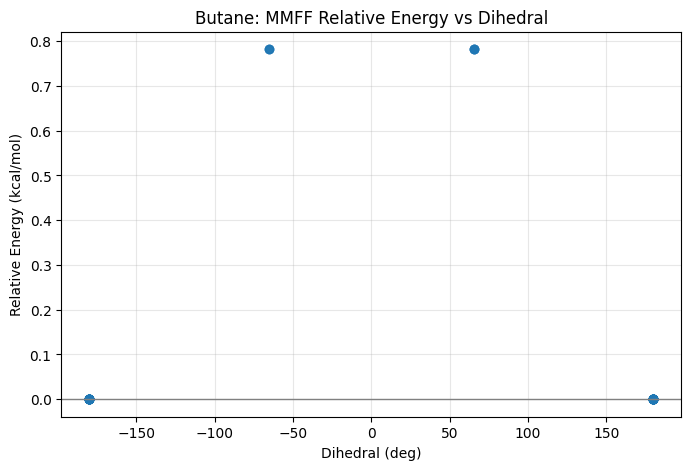

In [3]:
# Build butane and add hydrogens
butane = Chem.AddHs(Chem.MolFromSmiles('CCCC'))

# Generate conformers and energies (keeps RDKit conformer IDs)
butane, energy_df = generate_conformers(butane, n_conf=50, seed=42, rmsd_threshold=0.35)

# Central dihedral atom IDs: first four carbons
carbons = [a.GetIdx() for a in butane.GetAtoms() if a.GetAtomicNum() == 6]
dih_atoms = carbons[:4]

# Angles table and merged analysis
angles_df = dihedral_table(butane, dih_atoms)

df = energy_df.merge(angles_df, on='Conformer', how='inner')
df = df.sort_values('Energy').reset_index(drop=True)
df['RelE'] = df['Energy'] - df['Energy'].min()
print(df.head(50).to_string(index=False))

# View lowest-energy conformer
viewer = visualize_conformer(butane, conf_id=int(df.iloc[0]['Conformer']))
viewer.show()

# Plot energy vs dihedral
plt.figure(figsize=(8,5))
plt.scatter(df['Dihedral'], df['RelE'], c='tab:blue', alpha=0.7)
plt.axhline(0, color='gray', lw=1)
plt.xlabel('Dihedral (deg)')
plt.ylabel('Relative Energy (kcal/mol)')
plt.title('Butane: MMFF Relative Energy vs Dihedral')
plt.grid(True, alpha=0.3)
plt.show()

In [4]:
# How do we filter to just the three main conformers? RMSDs are troublesome when atom indices vary.

## Example: 1,2-Difluoroethane

Analyze the F–C–C–F dihedral using the same minimal workflow (conformers, energies, angles, plot).

 Conformer   Energy    Dihedral         RelE
       137 7.496308   72.065042 0.000000e+00
       139 7.496308  -72.065031 3.243628e-12
        26 7.496308   72.065016 8.482992e-12
        46 7.496308  -72.065065 9.865886e-12
       130 7.496308   72.065082 1.291589e-11
         2 7.496308   72.065115 2.837552e-11
        65 7.496308  -72.065089 2.860556e-11
        74 7.496308  -72.064998 4.880274e-11
        90 8.125751  179.999984 6.294432e-01
        39 8.125751 -179.999947 6.294432e-01
        49 8.125751  179.999954 6.294432e-01
       121 8.125751  179.999889 6.294432e-01


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

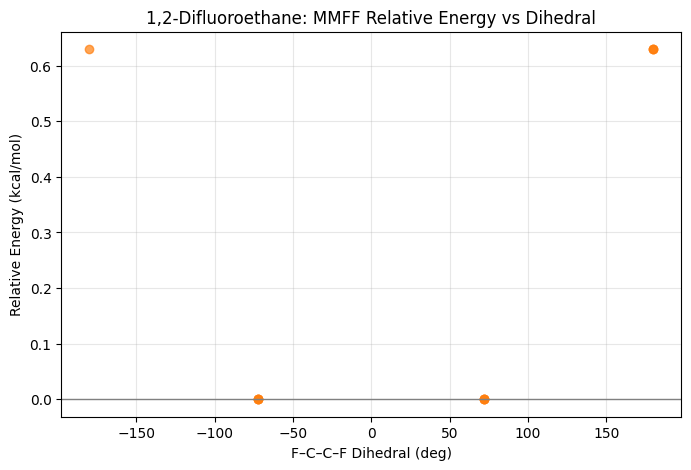

In [5]:
# Build 1,2-difluoroethane and add hydrogens
# SMILES: F-CH2-CH2-F  -> FCCF
# Use explicit fluorines to ensure correct atom selection
c2h4f2 = Chem.AddHs(Chem.MolFromSmiles('FCCF'))

# Generate conformers and energies
c2h4f2, energy_df = generate_conformers(c2h4f2, n_conf=50, seed=123, rmsd_threshold=0.35)

# Identify atom indices for F–C–C–F dihedral
F_idxs = [a.GetIdx() for a in c2h4f2.GetAtoms() if a.GetSymbol() == 'F']
C_idxs = [a.GetIdx() for a in c2h4f2.GetAtoms() if a.GetSymbol() == 'C']
# Sort to get a consistent chain order
F_idxs.sort(); C_idxs.sort()
fcCf = [F_idxs[0], C_idxs[0], C_idxs[1], F_idxs[1]]

# Angles/energies and merge
angles_df = dihedral_table(c2h4f2, fcCf)
df = energy_df.merge(angles_df, on='Conformer', how='inner')
df = df.sort_values('Energy').reset_index(drop=True)
df['RelE'] = df['Energy'] - df['Energy'].min()
print(df.head(50).to_string(index=False))

# Visualize lowest energy conformer
viewer = visualize_conformer(c2h4f2, conf_id=int(df.iloc[0]['Conformer']))
viewer.show()

# Plot energy vs F–C–C–F dihedral
plt.figure(figsize=(8,5))
plt.scatter(df['Dihedral'], df['RelE'], c='tab:orange', alpha=0.7)
plt.axhline(0, color='gray', lw=1)
plt.xlabel('F–C–C–F Dihedral (deg)')
plt.ylabel('Relative Energy (kcal/mol)')
plt.title('1,2-Difluoroethane: MMFF Relative Energy vs Dihedral')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Are those angles good? Check with a quantum chemistry package and compare with CREST.